In [5]:
#basic
import numpy as np 
import pandas as pd
import pickle

#visualization
import seaborn as sns
import matplotlib.pyplot as plt
color = sns.color_palette()
sns.set(font_scale = .6)

#others
from string import Template
import gc
import time
import itertools
from tqdm import tqdm, tqdm_notebook
import random
import warnings
warnings.filterwarnings('ignore')

#ML
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics
from xgboost.sklearn import XGBRegressor
import xgboost as xgb
#spark


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Load data

In [2]:
## Load data
path = "./data/"

item_categories = pd.read_csv(path+"item_categories.csv")
items = pd.read_csv(path+"items.csv")
shops = pd.read_csv(path+"shops.csv")
train = pd.read_csv(path+"sales_train.csv")
test = pd.read_csv(path+"test.csv")

print("Done!")

Done!


# Feature engineering

In [3]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    int8_features = ['shop_id', 'item_category_id', 'date_block_num', 'ID', 
                     'shop_running_months','recent_continuous_no_sales_months',
                    'month']
    int16_features = ['year', 'item_id']
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    int8_cols = [c for c in df if c in int8_features]
    int16_cols = [c for c in df if c in int16_features]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    df[int8_cols] = df[int8_cols].astype(np.int8)
    df[int16_cols] = df[int16_cols].astype(np.int16)
    
    return df

def generate_target_features(data):
    index_cols=['shop_id', 'item_id', 'date_block_num'] #'item_category_id',
    item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()
    
    last_date_block_num = int(data.date_block_num.max())
    full_combination_period = 13
    data = pd.merge(data, item_category_mapping, how='left', on='item_id')
    

    # For every month we create a grid from all shops/items combinations from that month
    grid = []
    for block_num in data['date_block_num'].unique():
        full_date_block_num = last_date_block_num - full_combination_period
        if block_num > full_date_block_num:
            # use full combination period
            cur_shops = data.loc[data['date_block_num'] > full_date_block_num, 'shop_id'].unique()
            cur_items = data.loc[data['date_block_num'] > full_date_block_num, 'item_id'].unique()
        else:
            # use current period combination
            cur_shops = data.loc[data['date_block_num'] == block_num, 'shop_id'].unique()
            cur_items = data.loc[data['date_block_num'] == block_num, 'item_id'].unique()
        grid.append(np.array(list(itertools.product(*[cur_shops, cur_items, [block_num]])),dtype='int16'))

    # Turn the grid into a dataframe
    grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int16)   
    grid = pd.merge(grid, item_category_mapping, how='left', on='item_id')

    # Groupby data to get shop-item-month aggregates
    gb = data.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
    # Fix column names
    gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
    # Join it to the grid
    all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)
    
    # Same as above but with shop-month aggregates
    gb = data.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
    gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
    all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

    # Same as above but with item-month aggregates
    gb = data.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
    gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
    all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

    
    # Same as above but with category-month aggregates
    gb = data.groupby(['item_category_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_category':'sum'}})
    gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
    # Category for each item 
    all_data = pd.merge(all_data, gb, how='left', on=['item_category_id', 'date_block_num']).fillna(0)
    
    
    # Downcast dtypes to save memory
    all_data = downcast_dtypes(all_data)
    del grid, gb 
    gc.collect()
    return all_data

def generate_date_feature(all_data):
    first_year = 2013
    unique_date_blocks = 35
    date_block_num_mapping_to_month = pd.DataFrame({'date_block_num': list(range(unique_date_blocks)),
                                                      'month': [int((x % 12)+1) for x in range(unique_date_blocks)]})
    date_block_num_mapping_to_year = pd.DataFrame({'date_block_num': list(range(unique_date_blocks)),
                                                      'year': [int(x/12.+first_year) for x in range(unique_date_blocks)]})
    all_data = pd.merge(all_data, date_block_num_mapping_to_month, how='left', on='date_block_num')
    all_data = pd.merge(all_data, date_block_num_mapping_to_year, how='left', on='date_block_num')
    all_data = downcast_dtypes(all_data)
    return all_data

def generate_lagged_features(all_data, is_test=False):
    index_cols_dict = {'target':['shop_id', 'item_id','date_block_num'],
                      'target_shop':['shop_id','date_block_num'],
                      'target_item':['item_id','date_block_num'],
                      'target_category':['item_category_id','date_block_num']}
    target_columns = [col for col in all_data.columns.values if 'target' in col]
    if is_test:
        shift_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
        all_data['date_block_num'] += 1
    else:
        shift_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

    if is_test:
        # update lagged 1 columns
        for col in target_columns:
            #all_data = all_data.rename(columns=(lambda x: '{}_lag_{}'.format(x, 1) if x in cols_to_rename else x))
            all_data['{}_lag_{}'.format(col, 1)] = all_data[col]
    #else:
        #Don't use old data from year 2013 for training
        #all_data = all_data[all_data['date_block_num'] >= 12]
        
    # loop over every target features
    for target_col in target_columns:
        # loop ever every lagged period
        for month_shift in shift_range:
            index_cols = index_cols_dict[target_col]
            train_shift = all_data[index_cols + [target_col]].drop_duplicates()
            train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
            if is_test:
                # modify test date_block_num
                foo = lambda x: '{}_lag_{}'.format(x, month_shift+1) if x == target_col else x
            else:
                foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x == target_col else x
            train_shift = train_shift.rename(columns=foo)
            all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

    del train_shift

    all_data = downcast_dtypes(all_data)
    gc.collect()
    return all_data

def generate_moving_features(all_data):
    target_lagged_features = [column for column in all_data.columns.values if 'target_lag_' in column]
    target_category_lagged_features = [column for column in all_data.columns.values if 'target_category_lag_' in column]
    target_item_lagged_features = [column for column in all_data.columns.values if 'target_item_lag_' in column]
    target_shop_lagged_features = [column for column in all_data.columns.values if 'target_shop_lag_' in column]
    for typ in ['target', 'target_category', 'target_item', 'target_shop']:
        for period in [3,6,9,12]:
            all_data[typ+'_ma_'+str(period)] = 0
            for i in range(period):
                all_data[typ+'_ma_'+str(period)] = all_data[typ+'_ma_'+str(period)] + all_data[typ+'_lag_'+str(i+1)]
            all_data[typ+'_ma_'+str(period)] = all_data[typ+'_ma_'+str(period)]/period

    all_data = downcast_dtypes(all_data)
    return all_data

def generate_item_price_statistic_features(all_data, train):
    item_price_statistic_encoding = train.groupby(['item_id']).item_price\
                        .agg([np.mean, np.std, np.max, np.min, len, lambda x: x.max()-x.min()])\
                        .fillna(0)\
                        .rename(columns={'<lambda>': 'item_price_diff',
                                        'mean': 'item_price_mean',
                                        'std': 'item_price_std',
                                        'amax': 'item_price_max',
                                        'amin': 'item_price_min',
                                        'len': 'item_price_count'})\
                        .reset_index()
    all_data = pd.merge(all_data, item_price_statistic_encoding, on='item_id', how='left').fillna(0)
    all_data = downcast_dtypes(all_data)
    del item_price_statistic_encoding
    gc.collect()
    return all_data

def generate_shop_item_price_statistic_features(all_data, train):
    shop_item_price_encoding = train.groupby(['shop_id', 'item_id']).item_price\
                        .agg([np.mean, np.std, np.max, np.min, len, lambda x: x.max()-x.min()])\
                        .fillna(0)\
                        .rename(columns={'<lambda>': 'shop_item_price_diff',
                                        'mean': 'shop_item_price_mean',
                                        'std': 'shop_item_price_std',
                                        'amax': 'shop_item_price_max',
                                        'amin': 'shop_item_price_min',
                                        'len': 'shop_item_price_count'})\
                        .reset_index()
    shop_item_price_statistic_features = ['shop_item_price_mean', 'shop_item_price_std', 'shop_item_price_max', 'shop_item_price_min', 'shop_item_price_count','shop_item_price_diff']
    df_shop_item_price_encoding.head()
    all_data = pd.merge(all_data, shop_item_price_encoding, on=['shop_id', 'item_id'], how='left').fillna(0)
    all_data = downcast_dtypes(all_data)
    del shop_item_price_encoding
    gc.collect()
    return all_data

def get_train_val_test_df(train, test, is_modeling=True):
    to_drop_train_cols = ['target', 'target_shop','target_category', 'target_item']
    to_drop_test_cols = ['ID','target', 'target_shop','target_category', 'target_item']

    all_data = generate_lagged_features(generate_target_features(train))
    all_data = generate_moving_features(all_data)
    all_data = get_sales_frequency_features(all_data)
    all_data = generate_item_price_statistic_features(all_data, train)
    all_data = generate_date_feature(all_data)
    all_data = generate_target_statistic_features(all_data)
    all_data = generate_economic_features(all_data)
    #all_data = generate_shop_item_price_statistic_features(all_data, train)

    #Don't use old data from year 2013 for training
    all_data = all_data[all_data['date_block_num'] >= 12]
    
    dates = all_data['date_block_num']
    last_block = dates.max()
    dates_train = dates[dates <  last_block]
    dates_val  = dates[dates == last_block]
    
    if is_modeling:
        X_train = downcast_dtypes(all_data.loc[dates <  last_block].drop(to_drop_train_cols, axis=1))
        X_val =  downcast_dtypes(all_data.loc[dates == last_block].drop(to_drop_train_cols, axis=1))

        y_train = all_data.loc[dates <  last_block, 'target'].clip(0,20).values
        y_val =  all_data.loc[dates == last_block, 'target'].clip(0,20).values
        
        return X_train, y_train, X_val, y_val
    else:
        X_train_final = downcast_dtypes(all_data.drop(to_drop_train_cols, axis=1))
        y_train_final = all_data.target.clip(0,20).values

        # generate test predict dataset
        all_data_test = generate_lagged_features(generate_target_features(train), is_test=True)
        all_data_test = generate_moving_features(all_data_test)
        all_data_test = get_sales_frequency_features(all_data_test)
        all_data_test = generate_item_price_statistic_features(all_data_test, train)
        all_data_test = generate_date_feature(all_data_test)
        all_data_test = generate_target_statistic_features(all_data_test)
        all_data_test = generate_economic_features(all_data_test)
        
        #Don't use old data from year 2013 for training
        all_data_test = all_data_test[all_data_test['date_block_num'] >= 12]

        X_test = downcast_dtypes(test.set_index(['shop_id','item_id'])\
            .join(all_data_test.loc[all_data_test['date_block_num'] == 34]\
            .set_index(['shop_id','item_id']), how='left')\
            .fillna(0)\
            .reset_index()\
            .drop(to_drop_test_cols, axis=1))
        
        X_test = X_test[X_train_final.columns]
        
        return X_train_final, y_train_final, X_test

def get_sales_frequency_features(all_data):
    all_data = all_data.set_index('shop_id')\
                        .join(all_data[['shop_id', 'target_shop','date_block_num']]\
                            .drop_duplicates()\
                            .pivot(index='shop_id', columns='date_block_num', values='target_shop')\
                            .apply(lambda x: len(x)-np.isnan(x).sum(), axis=1)\
                            .to_frame()\
                            .rename(columns={0: 'shop_running_months'})\
                            .astype({'shop_running_months': 'i1'}))\
                        .reset_index()
            
#     all_data = all_data.set_index('shop_id')\
#                         .join(all_data[['shop_id', 'target_shop','date_block_num']]\
#                             .drop_duplicates()\
#                             .pivot(index='shop_id', columns='date_block_num', values='target_shop')\
#                             .apply(np.isnan)\
#                             .apply(lambda s:len(s)-(s.index * s.apply(lambda x: int(x==False))).max()-1,axis=1)\
#                             .to_frame()\
#                             .rename(columns={0: 'shop_continuous_no_sales_months'})\
#                             .astype({'shop_continuous_no_sales_months': 'i1'}))\
#                         .reset_index() 
    
    all_data = downcast_dtypes(all_data)
    return all_data

def generate_shop_item_target_statistic_features(all_data):
    shop_item_target_encoding = all_data.groupby(['shop_id', 'item_id']).target\
                        .agg([np.mean, np.median, np.std, np.max, np.min, lambda x: x.max()-x.min()])\
                        .fillna(0)\
                        .rename(columns={'<lambda>': 'shop_item_target_diff',
                                        'mean': 'shop_item_target_mean',
                                        'median': 'shop_item_target_median',
                                        'std': 'shop_item_target_std',
                                        'amax': 'shop_item_target_max',
                                        'amin': 'shop_item_target_min'})\
                        .reset_index()
    all_data = pd.merge(all_data, shop_item_target_encoding, on=['shop_id', 'item_id'], how='left').fillna(0)
    all_data = downcast_dtypes(all_data)
    del shop_item_target_encoding
    gc.collect()
    return all_data

def generate_shop_target_statistic_features(all_data):
    shop_target_encoding = all_data.groupby(['shop_id']).target\
                        .agg([np.mean, np.median, np.std, np.max, np.min, lambda x: x.max()-x.min()])\
                        .fillna(0)\
                        .rename(columns={'<lambda>': 'shop_target_diff',
                                        'mean': 'shop_target_mean',
                                        'median': 'shop_target_median',
                                        'std': 'shop_target_std',
                                        'amax': 'shop_target_max',
                                        'amin': 'shop_target_min'})\
                        .reset_index()
    all_data = pd.merge(all_data, shop_target_encoding, on=['shop_id'], how='left').fillna(0)
    all_data = downcast_dtypes(all_data)
    del shop_target_encoding
    gc.collect()
    return all_data

def generate_item_target_statistic_features(all_data):
    item_target_encoding = all_data.groupby(['item_id']).target\
                        .agg([np.mean, np.median, np.std, np.max, np.min, lambda x: x.max()-x.min()])\
                        .fillna(0)\
                        .rename(columns={'<lambda>': 'item_target_diff',
                                        'mean': 'item_target_mean',
                                        'median': 'item_target_median',
                                        'std': 'item_target_std',
                                        'amax': 'item_target_max',
                                        'amin': 'item_target_min'})\
                        .reset_index()
    all_data = pd.merge(all_data, item_target_encoding, on=['item_id'], how='left').fillna(0)
    all_data = downcast_dtypes(all_data)
    del item_target_encoding
    gc.collect()
    return all_data

def generate_category_target_statistic_features(all_data):
    category_target_encoding = all_data.groupby(['item_category_id']).target\
                        .agg([np.mean, np.median, np.std, np.max, np.min, lambda x: x.max()-x.min()])\
                        .fillna(0)\
                        .rename(columns={'<lambda>': 'category_target_diff',
                                        'mean': 'category_target_mean',
                                        'median': 'category_target_median',
                                        'std': 'category_target_std',
                                        'amax': 'category_target_max',
                                        'amin': 'category_target_min'})\
                        .reset_index()
    all_data = pd.merge(all_data, category_target_encoding, on=['item_category_id'], how='left').fillna(0)
    all_data = downcast_dtypes(all_data)
    del category_target_encoding
    gc.collect()
    return all_data

def generate_target_statistic_features(all_data):
    all_data = generate_shop_item_target_statistic_features(all_data)
    all_data = generate_shop_target_statistic_features(all_data)
    all_data = generate_category_target_statistic_features(all_data)
    all_data = generate_item_target_statistic_features(all_data)
    return all_data

def generate_economic_features(all_data, path="./external_data/economic_data.csv"):
    economic_df = pd.read_csv(path)
    all_data = pd.merge(all_data, economic_df, on='date_block_num', how='left')
    all_data = downcast_dtypes(all_data)
    del economic_df
    gc.collect()
    return all_data

In [4]:
all_data = generate_target_features(train)

In [4]:
X_train, y_train, X_val, y_val = get_train_val_test_df(train,test, True)

In [36]:
#X_train, y_train, X_val, y_val = get_train_val_test_df(train,test, True)

In [4]:
#X_train_final, y_train_final, X_test = get_train_val_test_df(train,test, False)

In [31]:
del X_train
del y_train
del X_val
del y_val
# del X_train_final
# del y_train_final
# del X_test

In [6]:
X_train_final['target'] = y_train_final
del y_train_final
gc.collect()

221

In [7]:
all_data[(all_data.shop_id==59)&(all_data.item_id==22155)][['shop_id', 'item_id','date_block_num','target_shop']+target_shop_lagged_features]

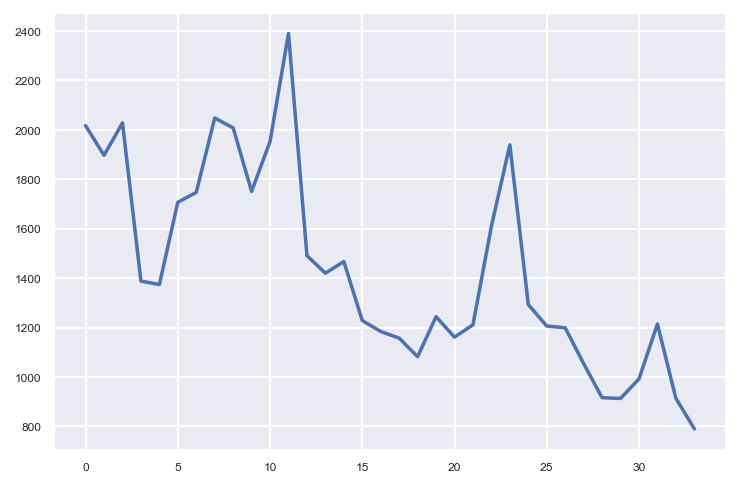

In [28]:
plt.plot(s.date_block_num,s.target)

## Text features

In [6]:
shop_word_vec = CountVectorizer()
shop_word_count = shop_word_vec.fit_transform(shops.shop_name).toarray().astype(np.int8)
shop_word_filter = shop_word_count.sum(axis=0) > 1
shop_word_features = np.array(shop_word_vec.get_feature_names())[shop_word_filter]
shop_word_features = ['shop_word_' + f for f in shop_word_features.tolist()]

In [7]:
shops = pd.concat(
    [
        shops,
        pd.DataFrame(shop_word_count[:,shop_word_filter], columns=shop_word_features).to_sparse(fill_value=0)
    ], axis=1
)
shops.head()

,shop_name,shop_id,shop_word_56,shop_word_ii,shop_word_буденовский,shop_word_век,shop_word_воронеж,shop_word_горизонт,shop_word_жуковский,shop_word_казань,...,shop_word_трк,shop_word_трц,shop_word_тц,shop_word_тюмень,shop_word_ул,shop_word_уфа,shop_word_фран,shop_word_центральный,shop_word_чкалова,shop_word_якутск
0,"!Якутск Орджоникидзе, 56 фран",0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,"!Якутск ТЦ ""Центральный"" фран",1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,1,0,1
2,"Адыгея ТЦ ""Мега""",2,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,"Волжский ТЦ ""Волга Молл""",4,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [8]:
item_word_vec = CountVectorizer()
item_word_count = item_word_vec.fit_transform(items.item_name).toarray().astype(np.int8)
item_word_filter = item_word_count.sum(axis=0) > 1
item_word_features = np.array(item_word_vec.get_feature_names())[item_word_filter]
item_word_features = ['item_word_' + f for f in item_word_features.tolist()]

In [9]:
items = pd.concat(
    [
        items,
        pd.DataFrame(item_word_count[:,item_word_filter], columns=item_word_features).to_sparse(fill_value=0)
    ], axis=1
)
items.head()

,item_name,item_id,item_category_id,item_word_000,item_word_00002,item_word_00003,item_word_00005,item_word_00008,item_word_00010,item_word_00011,...,item_word_ярмарка,item_word_ярослав,item_word_ярости,item_word_ярость,item_word_ястреб,item_word_ящик,item_word_ёлка,item_word_ёлки,item_word_ёлочка,item_word_ёрш
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,***КОРОБКА (СТЕКЛО) D,4,40,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
category_word_vec = CountVectorizer()
category_word_count = category_word_vec.fit_transform(items.item_name).toarray().astype(np.int8)
category_word_filter = category_word_count.sum(axis=0) > 1
category_word_features = np.array(category_word_vec.get_feature_names())[category_word_filter]
category_word_features = ['category_word_' + f for f in category_word_features.tolist()]

In [11]:
item_categories = pd.concat(
    [
        item_categories,
        pd.DataFrame(category_word_count[:,category_word_filter], columns=category_word_features).to_sparse(fill_value=0)
    ], axis=1
)
item_categories.head()

,item_category_name,item_category_id,category_word_000,category_word_00002,category_word_00003,category_word_00005,category_word_00008,category_word_00010,category_word_00011,category_word_00012,...,category_word_ярмарка,category_word_ярослав,category_word_ярости,category_word_ярость,category_word_ястреб,category_word_ящик,category_word_ёлка,category_word_ёлки,category_word_ёлочка,category_word_ёрш
0,PC - Гарнитуры/Наушники,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Аксессуары - PS2,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Аксессуары - PS3,2.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Аксессуары - PS4,3.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Аксессуары - PSP,4.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
all_data = train.groupby(['shop_id', 'item_id', 'date_block_num'], as_index=False)\
    .agg({'item_cnt_day':'sum'})\
    .rename(columns={'item_cnt_day':'target'})\
    .merge(shops, on='shop_id', how='left')\
    .merge(items, on='item_id',how='left')

In [14]:
all_data = all_data.to_sparse(fill_value=0)#..head()#.drop(['shop_name', 'item_name', 'item_categories_id']).head()

In [23]:
#shops.shop_name
all_data.head()

KeyboardInterrupt: 

## Time features

In [70]:
all_data[(all_data.shop_id == 59) & (all_data.item_id == 22143)][['shop_id', 'item_id', 'date_block_num', 'target', 'target_lag_1']]

,shop_id,item_id,date_block_num,target,target_lag_1
5250132,59,22143,14,6.0,0.0
5556150,59,22143,15,1.0,6.0
5846296,59,22143,16,0.0,1.0
6213763,59,22143,17,0.0,0.0
6501206,59,22143,18,0.0,0.0
6961235,59,22143,19,1.0,0.0
7435800,59,22143,20,0.0,1.0
7665278,59,22143,21,0.0,0.0
7820388,59,22143,22,0.0,0.0


## Economic series features

In [47]:
economic_df = pd.read_csv("./external_data/economic_data.csv")

In [48]:
economic_df

,date_block_num,M2_growth,CPI
0,0,0.097959,0.0100
1,1,-0.030035,0.0056
2,2,0.015929,0.0034
3,3,0.016071,0.0051
4,4,0.006563,0.0066
5,5,0.007901,0.0042
6,6,0.022429,0.0082
7,7,0.008209,0.0014
8,8,0.001969,0.0021
9,9,-0.005168,0.0057


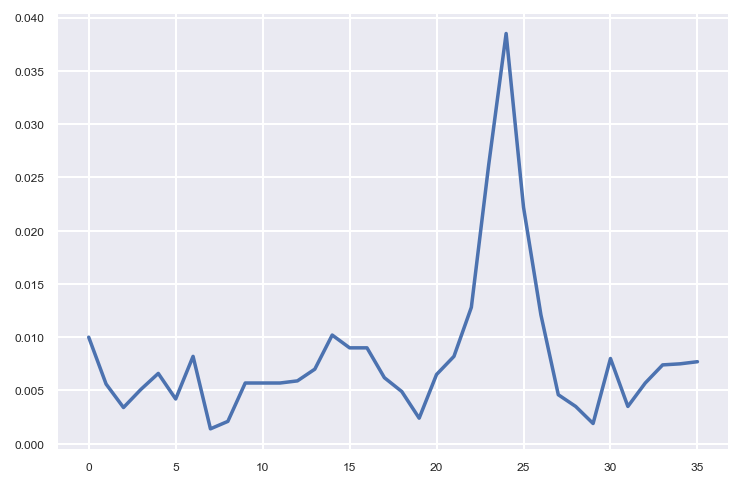

In [39]:
plt.plot(economic_df.)

In [37]:
#all_data = generate_economic_features(all_data)

all_data.

# Model training

In [24]:
#xgdmat = xgb.DMatrix(X_train, y_train)

In [ ]:
xgdmat_val = xgb.DMatrix(X_val, y_val)

In [23]:
#X_train.to_pickle("X_train.data")

In [21]:
gc.collect()

472

In [24]:
xg_reg = XGBRegressor(n_estimators=100,max_depth=9,nthread=4,seed=7)
xg_reg.fit(xgdmat)
xg_pred = xg_reg.predict(X_val).clip(0,20)
rmse = np.sqrt(mean_squared_error(y_val, xg_pred))
r2 = r2_score(y_val, xg_pred)
print('Model: %s, RMSE: %f, R2: %f' % ('xgboost regression', rmse, r2))

Model: xgboost regression, RMSE: 0.903258, R2: 0.367954


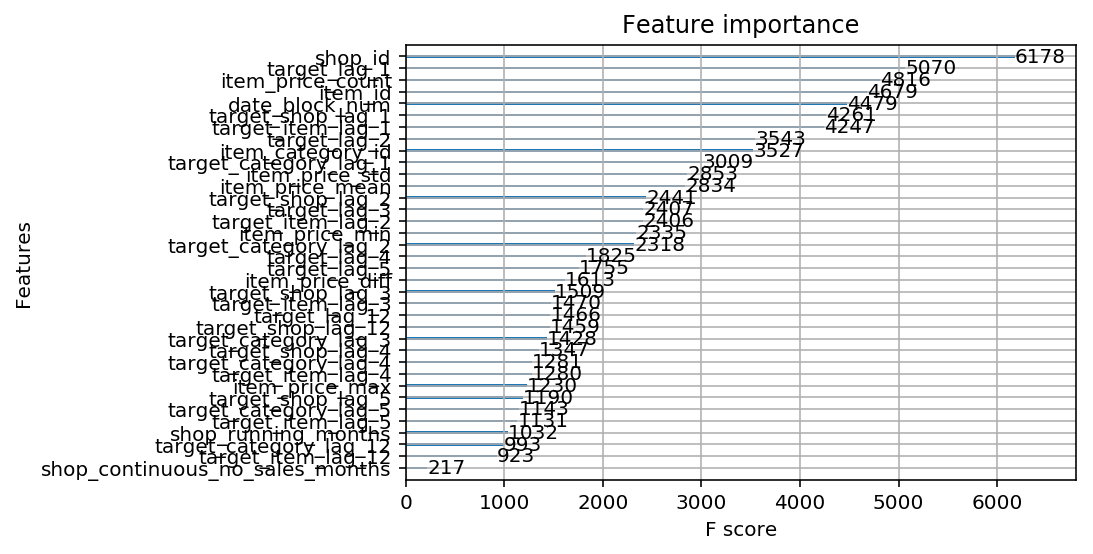

In [26]:
xgb.plot_importance(xg_reg)

In [26]:
#pickle.dump(best_xg_model, open('best_xg_model.sav', 'wb'))

In [12]:
xg_reg.score(X_val, y_val)

0.32510908567000862

In [29]:
xg_reg2 = XGBRegressor(n_estimators=100,max_depth=9,nthread=4,seed=7,subsample=0.9)
xg_reg2.fit(X_train, y_train)
xg_pred2 = xg_reg2.predict(X_val).clip(0,20)
rmse = np.sqrt(mean_squared_error(y_val, xg_pred2))
r2 = r2_score(y_val, xg_pred2)
print('Model: %s, RMSE: %f, R2: %f' % ('xgboost regression', rmse, r2))

Model: xgboost regression, RMSE: 0.914581, R2: 0.352009


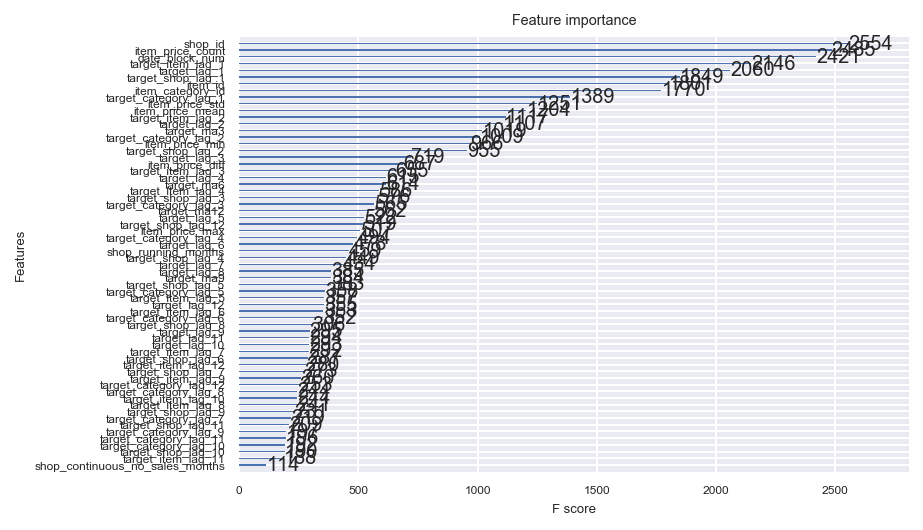

In [30]:
xgb.plot_importance(xg_reg2)

In [ ]:
xg_reg3 = XGBRegressor(n_estimators=100,max_depth=9,nthread=4,seed=7,subsample=0.9)
xg_reg3.fit(X_train, y_train)
xg_pred3 = xg_reg3.predict(X_val).clip(0,20)
rmse = np.sqrt(mean_squared_error(y_val, xg_pred3))
r2 = r2_score(y_val, xg_pred3)
print('Model: %s, RMSE: %f, R2: %f' % ('xgboost regression', rmse, r2))

In [38]:
# from sklearn.decomposition import PCA

# pca = PCA()#n_components=3
# fit = pca.fit(X_train)

# #Summarize components
# print("Explained Variance: %s" % fit.explained_variance_ratio_)
# print(fit.components_)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=40, max_depth=4, random_state=0,n_jobs=4)
rf_reg.fit(X_train, y_train)
rf_reg_pred = rf_reg.predict(X_val).clip(0,20)
rmse = np.sqrt(mean_squared_error(y_val, rf_reg_pred))
r2 = r2_score(y_val, rf_reg_pred)
print('Model: %s, RMSE: %f, R2: %f' % ('rf regression', rmse, r2))

(6186922, 81)

In [ ]:
X_train2 = X_train.copy()
X_val2 = X_val.copy()

shop_unique_ids = sorted(train.shop_id.unique())

shop_one_hot_encoder = OneHotEncoder(len(shop_unique_ids), dtype=np.int8)
shop_one_hot_encoder.fit(train.shop_id.reshape(-1, 1))
shop_arr = shop_one_hot_encoder.transform(X_train2.shop_id.reshape(-1, 1)).toarray()

shop_one_hot_features = ['shop_'+str(shop_id) for shop_id in shop_unique_ids]
X_train2[shop_one_hot_features] = pd.DataFrame(shop_arr, columns=shop_one_hot_features).to_sparse(fill_value=0)

## Model notes

* xgboost with 200 estimators and 9 depth gets RMSE: 0.903258, R2: 0.367954
* xgboost with 200 estimators and 9 depth, but include earlier data gets RMSE: 0.914712, R2: 0.351823
* xgboost with 200 estimators and 9 depth, include more lagged features gets RMSE: 0.911888, R2: 0.355819